<a href="https://colab.research.google.com/github/pacoiniesta/NBA-SALARY-ANALYZE-2022/blob/main/ANALISIS_NBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#REALIZACIÓN DEL PROYECTO WITH OOP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.4 MB/s 
     |████████████████████████████████| 133 kB 51.9 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=d6b6787cbd4f93fa5c104526f6f51247e05758a0845b0c2538c40c57cceffd52
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

In [3]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 257 kB/s 
     |████████████████████████████████| 13.1 MB 20.3 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=bf749ad2a5233e58abc2a737a430a140d7b7a7f292e8fad2aca7c07f32930027
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
!pip install pdp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pdp: filename=pdp-0.3.0-py3-none-any.whl size=6616 sha256=f073505570f4fa1e31b71e09841555a859f3e755980734d3e4a792df4c3a21a6
  Stored in directory: /root/.cache/pip/wheels/86/3f/21/790268989f0e594527d3b781d80e150499eb918f8c88c1509a
Successfully built pdp


In [5]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 8.0 MB/s 


In [60]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
import sklearn.metrics
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap
import warnings
import pickle

In [61]:
class SALARY_ANALYZER(object):
  def __init__(self, data_route, nombre_jugador='all', normalize=False, characters='.', test_size=0.40, random_state=14):
      self.data_route=data_route
      self.nombre_jugador=nombre_jugador
      self.data = pd.DataFrame()
      self.normalize=normalize
      self.characters=characters
      self.data_TrainX=pd.DataFrame()
      self.data_TrainY=pd.DataFrame()
      self.data_ValX=pd.DataFrame()
      self.data_ValY=pd.DataFrame()
      self.actual_salary=pd.Series()
      self.predicted_salary=pd.Series()
      self.player_name=pd.Series()
      self.test_size=test_size
      self.random_state=random_state
      self.player_name=pd.Series()
      self.model=[]

  def Load_Data(self):
    print('Loading Data.....')
    self.data = pd.read_excel(self.data_route, header=0)
  
  def Prepare_Data(self):
    #Deleting dollar symbol in SALARY column
    for i in range(self.data.shape[0]):
      self.data['SALARIO 2021-22'][i]=self.data['SALARIO 2021-22'][i][1:]
    #Deleting point symbol in SALARY column
    for i in range(self.data.shape[0]):
      self.data['SALARIO 2021-22'][i]=''.join(x for x in self.data['SALARIO 2021-22'][i] if x not in self.characters)
    #Deleting samples with dual contract
    self.data=self.data[self.data['SALARIO 2021-22']!='ual']
    #Converting SALARY into float, it came as character
    self.data['SALARIO 2021-22']=self.data['SALARIO 2021-22'].astype(float)
    #Deleting columns which does not apport information
    self.data.drop(columns=['Rk', 'Player', 'FG', 'FT', 'TRB', 'PF'], axis=1, inplace=True)
    #Replacing Nan values with 0
    self.data.fillna(0, inplace=True)

  def Add_Variables(self):    
    #Adding new variables
    self.data['TiNBAE']=self.data['Age']-20
    self.data['PPP']=self.data['PTS']/self.data['G']
    self.data['RPP']=(self.data['ORB']+self.data['DRB'])/self.data['G']
    self.data['2PP']=self.data['2P']/self.data['G']
    self.data['3PP']=self.data['3P']/self.data['G']
    self.data['FGAPP']=self.data['FGA']/self.data['G']
    self.data['2PAPP']=self.data['2PA']/self.data['G']
    self.data['3PAPP']=self.data['3PA']/self.data['G']
    self.data['ASTPP']=self.data['AST']/self.data['G']
    self.data['TOVPP']=self.data['TOV']/self.data['G']
    self.data['BLKPP']=self.data['BLK']/self.data['G']
    self.data['STLPP']=self.data['STL']/self.data['G']
    self.data['MPP']=self.data['MP']/self.data['G']

  def Normalizer(self):

    if self.normalize==True:
      data_salary_norm=pd.DataFrame()
      #Normalizing salary
      data_salary_norm['JUGADOR']=data_salary_norm['JUGADOR']
      data_salary_norm['SALARIO 2021-22']=(self.data['SALARIO 2021-22']-self.data['SALARIO 2021-22'].mean())/self.data['SALARIO 2021-22'].std()
      data_salary_norm['Tm']=self.data['Tm']
      data_salary_norm['Pos']=self.data['Pos']
      #Adding Team, Player name and position to data_salary_norm
      continous_var_norm=(self.data.iloc[:,4:]-self.data.iloc[:,4:].mean())/self.data.iloc[:,4:].std()
      #Merging two datasets modified previously
      data_output=pd.concat([data_salary_norm, continous_var_norm], axis=1)

    else:
      data_output=self.data
    
    return data_output

  def Describing_Data(self, data_output):
    return data_output.describe()
  
  def Correlation_Matrix(self, data_output):
    features = data_output.columns

    df = pd.DataFrame(data_output, columns = features)

    correlation_mat = df.corr()

    fig, ax = plt.subplots(figsize=(40,26))
    grafica=sns.heatmap(correlation_mat, vmin=-1, vmax=1,annot=True, linewidths=0.1, cmap='bwr',ax=ax, fmt=".3f", annot_kws={"size":10})

    plt.title('Correlation matrix SALARY/STADISTICS_NBA', fontsize=15)
    grafica.set(ylabel='Continous Variables salary and stadistics')
    plt.show()

  def Split_and_Dummy_Data(self, data_output):
    #Covariables of the model
    data_COV = data_output.drop(columns=['SALARIO 2021-22'], axis=1)
    data_COV_DUM = pd.get_dummies(data_COV, columns=['Tm', 'Pos'])
    #Response variable
    data_SALARY=data_output['SALARIO 2021-22']

    self.data_TrainX, self.data_ValX, self.data_TrainY, self.data_ValY = train_test_split(data_COV_DUM, data_SALARY, 
                                                                                           test_size=self.test_size,shuffle=True, random_state=self.random_state)

  def Grid_Search_and_Fit(self):
  # Create the random grid
    random_grid = {'n_estimators': [100, 200, 300, 400],
               'max_depth': [25,27,28,30,32],
               'learning_rate': [0.1, 0.05, 0.01, 0.001],
               'num_leaves': [15,25,27,28,30,32],
               'subsample_for_bin': [1000, 5000, 10000, 15000, 20000, 25000]}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    lgbr = LGBMRegressor()
    # Random search of parameters, using 5 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    lgbr_NBA= RandomizedSearchCV(estimator = lgbr, param_distributions = random_grid, 
                               scoring='neg_mean_squared_error' , n_iter = 100, cv = 5, 
                               verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    lgbr_NBA.fit(self.data_TrainX.iloc[:,1:], self.data_TrainY)

    self.actual_salary=self.data_ValY



    lgbr_FINAL=lgbr_NBA.best_estimator_
    lgbr_FINAL.fit(self.data_TrainX.iloc[:,1:], self.data_TrainY)

    self.model.append(lgbr_FINAL)

    self.predicted_salary = lgbr_FINAL.predict(self.data_ValX.iloc[:,1:])
    self.player_name = self.data_ValX['JUGADOR']
  
  def Create_Excel(self):
    if self.normalize==True:
      mean_salary = self.data_TrainY.mean()
      std_salary = self.data_TrainY.std()
      

      df_SALARIAL_REPORT=pd.DataFrame()

      df_SALARIAL_REPORT['Player'] = self.player_name
      df_SALARIAL_REPORT['Actual_Salary'] = self.actual_salary*std_salary+mean_salary
      df_SALARIAL_REPORT['Predicted_Salary'] = self.predicted_salary*std_salary+mean_salary
      df_SALARIAL_REPORT['Abs_Salary_Diff'] = abs(df_SALARIAL_REPORT['Predicted_Salary']-df_SALARIAL_REPORT['Actual_Salary'])
      df_SALARIAL_REPORT['Actual_Predict_Sal_Diff'] = df_SALARIAL_REPORT['Predicted_Salary']-df_SALARIAL_REPORT['Actual_Salary']
      df_SALARIAL_REPORT['Relative_Salary_Diff_NoAbs'] = df_SALARIAL_REPORT['Actual_Predict_Sal_Diff']/df_SALARIAL_REPORT['Actual_Salary']
      df_SALARIAL_REPORT['Relative_Salary_Diff'] = df_SALARIAL_REPORT['Abs_Salary_Diff']/df_SALARIAL_REPORT['Actual_Salary']


      df_SALARIAL_REPORT.to_excel('Salarial_Report_NBA.xlsx')

    else:
      df_SALARIAL_REPORT=pd.DataFrame()

      df_SALARIAL_REPORT['Player'] = self.player_name
      df_SALARIAL_REPORT['Actual_Salary'] = self.actual_salary
      df_SALARIAL_REPORT['Predicted_Salary'] = self.predicted_salary
      df_SALARIAL_REPORT['Abs_Salary_Diff'] = abs(df_SALARIAL_REPORT['Predicted_Salary']-df_SALARIAL_REPORT['Actual_Salary'])
      df_SALARIAL_REPORT['Actual_Predict_Sal_Diff'] = df_SALARIAL_REPORT['Predicted_Salary']-df_SALARIAL_REPORT['Actual_Salary']
      df_SALARIAL_REPORT['Relative_Salary_Diff_NoAbs'] = df_SALARIAL_REPORT['Actual_Predict_Sal_Diff']/df_SALARIAL_REPORT['Actual_Salary']
      df_SALARIAL_REPORT['Relative_Salary_Diff'] = df_SALARIAL_REPORT['Abs_Salary_Diff']/df_SALARIAL_REPORT['Actual_Salary']


      df_SALARIAL_REPORT.to_excel('Salarial_Report_NBA.xlsx')
  
  def Feature_Importance(self):
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(self.model[0].feature_importances_,self.data_TrainX.iloc[:,1:].columns)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Regressor Features (avg over folds)')
    plt.tight_layout()
    plt.show()
 #   plt.savefig('lgbm_importances-01.png')

 #   ax = self.model[0].plot_importance(self.model[0], max_num_features=100, figsize=(25,75))
 #   plt.show()

 #   plt.bar(range(len(self.model[0].feature_importances_)), self.model[0].feature_importances_)
 #   plt.show()

  def Permutation_Importance_Features(self):
    perm = PermutationImportance(self.model[0], random_state=1).fit(self.data_TrainX.iloc[:,1:], self.data_TrainY)
    plot = eli5.show_weights(perm, feature_names= self.data_ValX.iloc[:,1:].columns.tolist())
    return plot
  def Features_Report(self):
    feat_report=pd.DataFrame()
    feat_report['Feature_Name']=self.data_ValX.iloc[:,1:].columns
    return feat_report.head(50)

  def PDP(self, feature_number):
    feature_names=self.data_ValX.iloc[:,1:].columns.tolist()
    feature_to_plot=feature_names[feature_number]
    
    pdp_dist= pdp.pdp_isolate(model=self.model[0], dataset=self.data_ValX.iloc[:,1:], model_features=feature_names, feature=feature_to_plot)

    pdp.pdp_plot(pdp_dist, feature_to_plot)
    plt.show()
  
  def Heatmap_Salary(self, feature1_number, feature2_number):
    feature_names=self.data_ValX.iloc[:,1:].columns.tolist()
    features_to_plot = [feature_names[feature1_number], feature_names[feature2_number]]

    inter1=pdp.pdp_interact(model=self.model[0], dataset=self.data_ValX.iloc[:,1:], model_features=feature_names, features=features_to_plot)

    pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot)
    plt.show()

  def Shap_Individual(self, row_to_show):
    data_for_prediction = self.data_ValX.iloc[row_to_show,1:]
    data_for_prediction_array = data_for_prediction.values.reshape(1,-1)
   
    k_explainer = shap.KernelExplainer(self.model[0].predict, self.data_TrainX.iloc[:,1:])
    k_shap_values = k_explainer.shap_values(data_for_prediction)
    
    shap.initjs()
    return shap.force_plot(k_explainer.expected_value, k_shap_values, data_for_prediction)
  
  def Shap_Individual_Decision_Plot(self, row_to_show):
    data_for_prediction = self.data_ValX.iloc[row_to_show,1:]
    data_for_prediction_array = data_for_prediction.values.reshape(1,-1)
    k_explainer = shap.KernelExplainer(self.model[0].predict, self.data_TrainX.iloc[:,1:])
    k_shap_values = k_explainer.shap_values(data_for_prediction)
    features=self.data_ValX.columns.values

    shap.initjs()
    return shap.decision_plot(k_explainer.expected_value, k_shap_values, feature_names = list(features[1:])) 

  def Save_Model(self):
    pkl_filename= 'pickle_model.pkl'
    with open(pkl_filename, 'wb') as file:
      pickle.dump(self.model[0], file)


  def Report_Player(self, n_players):
    for i in range(n_players):
      print('El salario actual del jugador:')
      print(self.player_name.iloc[i])
      print('es de la cantidad de:')
      print(self.actual_salary.iloc[i])
      print('y el modelo predice que debería cobrar:')
      print(self.predicted_salary[i])

#Trabajando con la clase SALARY_ANALYZER

In [62]:
Proyecto=SALARY_ANALYZER(data_route='/content/drive/MyDrive/datos_NBA.xlsx')
Proyecto.Load_Data()

Loading Data.....


In [63]:
Proyecto.Prepare_Data()

In [64]:
Proyecto.Add_Variables()

In [65]:
Proyecto.Describing_Data(Proyecto.Normalizer()).head(9)

,SALARIO 2021-22,Age,G,GS,MP,FGA,FG%,3P,3PA,3P%,...,2PP,3PP,FGAPP,2PAPP,3PAPP,ASTPP,TOVPP,BLKPP,STLPP,MPP
count,5.530000e+02,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,...,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000
mean,6.672121e+06,25.952984,45.399638,22.001808,1051.748644,384.063291,0.439345,54.090416,152.858951,0.286338,...,2.237635,0.954691,7.019317,4.243033,2.776284,1.968702,1.065561,0.387079,0.631144,19.741535
std,9.091298e+06,4.185633,25.284493,26.235313,803.342273,355.427220,0.136981,60.587155,162.243058,0.141863,...,1.843613,0.876285,4.838876,3.362347,2.288831,1.865831,0.835428,0.381287,0.411984,9.515625
min,5.317600e+04,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.255785e+06,23.000000,23.000000,1.000000,302.000000,90.000000,0.399000,4.000000,16.000000,0.250000,...,0.941176,0.242424,3.500000,1.708333,0.978723,0.666667,0.515152,0.134328,0.333333,12.500000
50%,2.641691e+06,25.000000,51.000000,8.000000,975.000000,294.000000,0.445000,32.000000,97.000000,0.329000,...,1.772727,0.743590,5.766234,3.309859,2.256410,1.327869,0.855072,0.300000,0.577465,19.250000
75%,8.600000e+06,29.000000,67.000000,40.000000,1728.000000,571.000000,0.500000,83.000000,251.000000,0.371000,...,3.052632,1.431034,9.405797,5.666667,4.186667,2.580247,1.359375,0.506329,0.888889,27.680000
max,4.578097e+07,41.000000,82.000000,82.000000,2854.000000,1564.000000,1.000000,285.000000,750.000000,1.000000,...,9.526316,4.453125,21.803571,18.328947,11.718750,10.800000,4.492308,2.809524,2.333333,43.500000


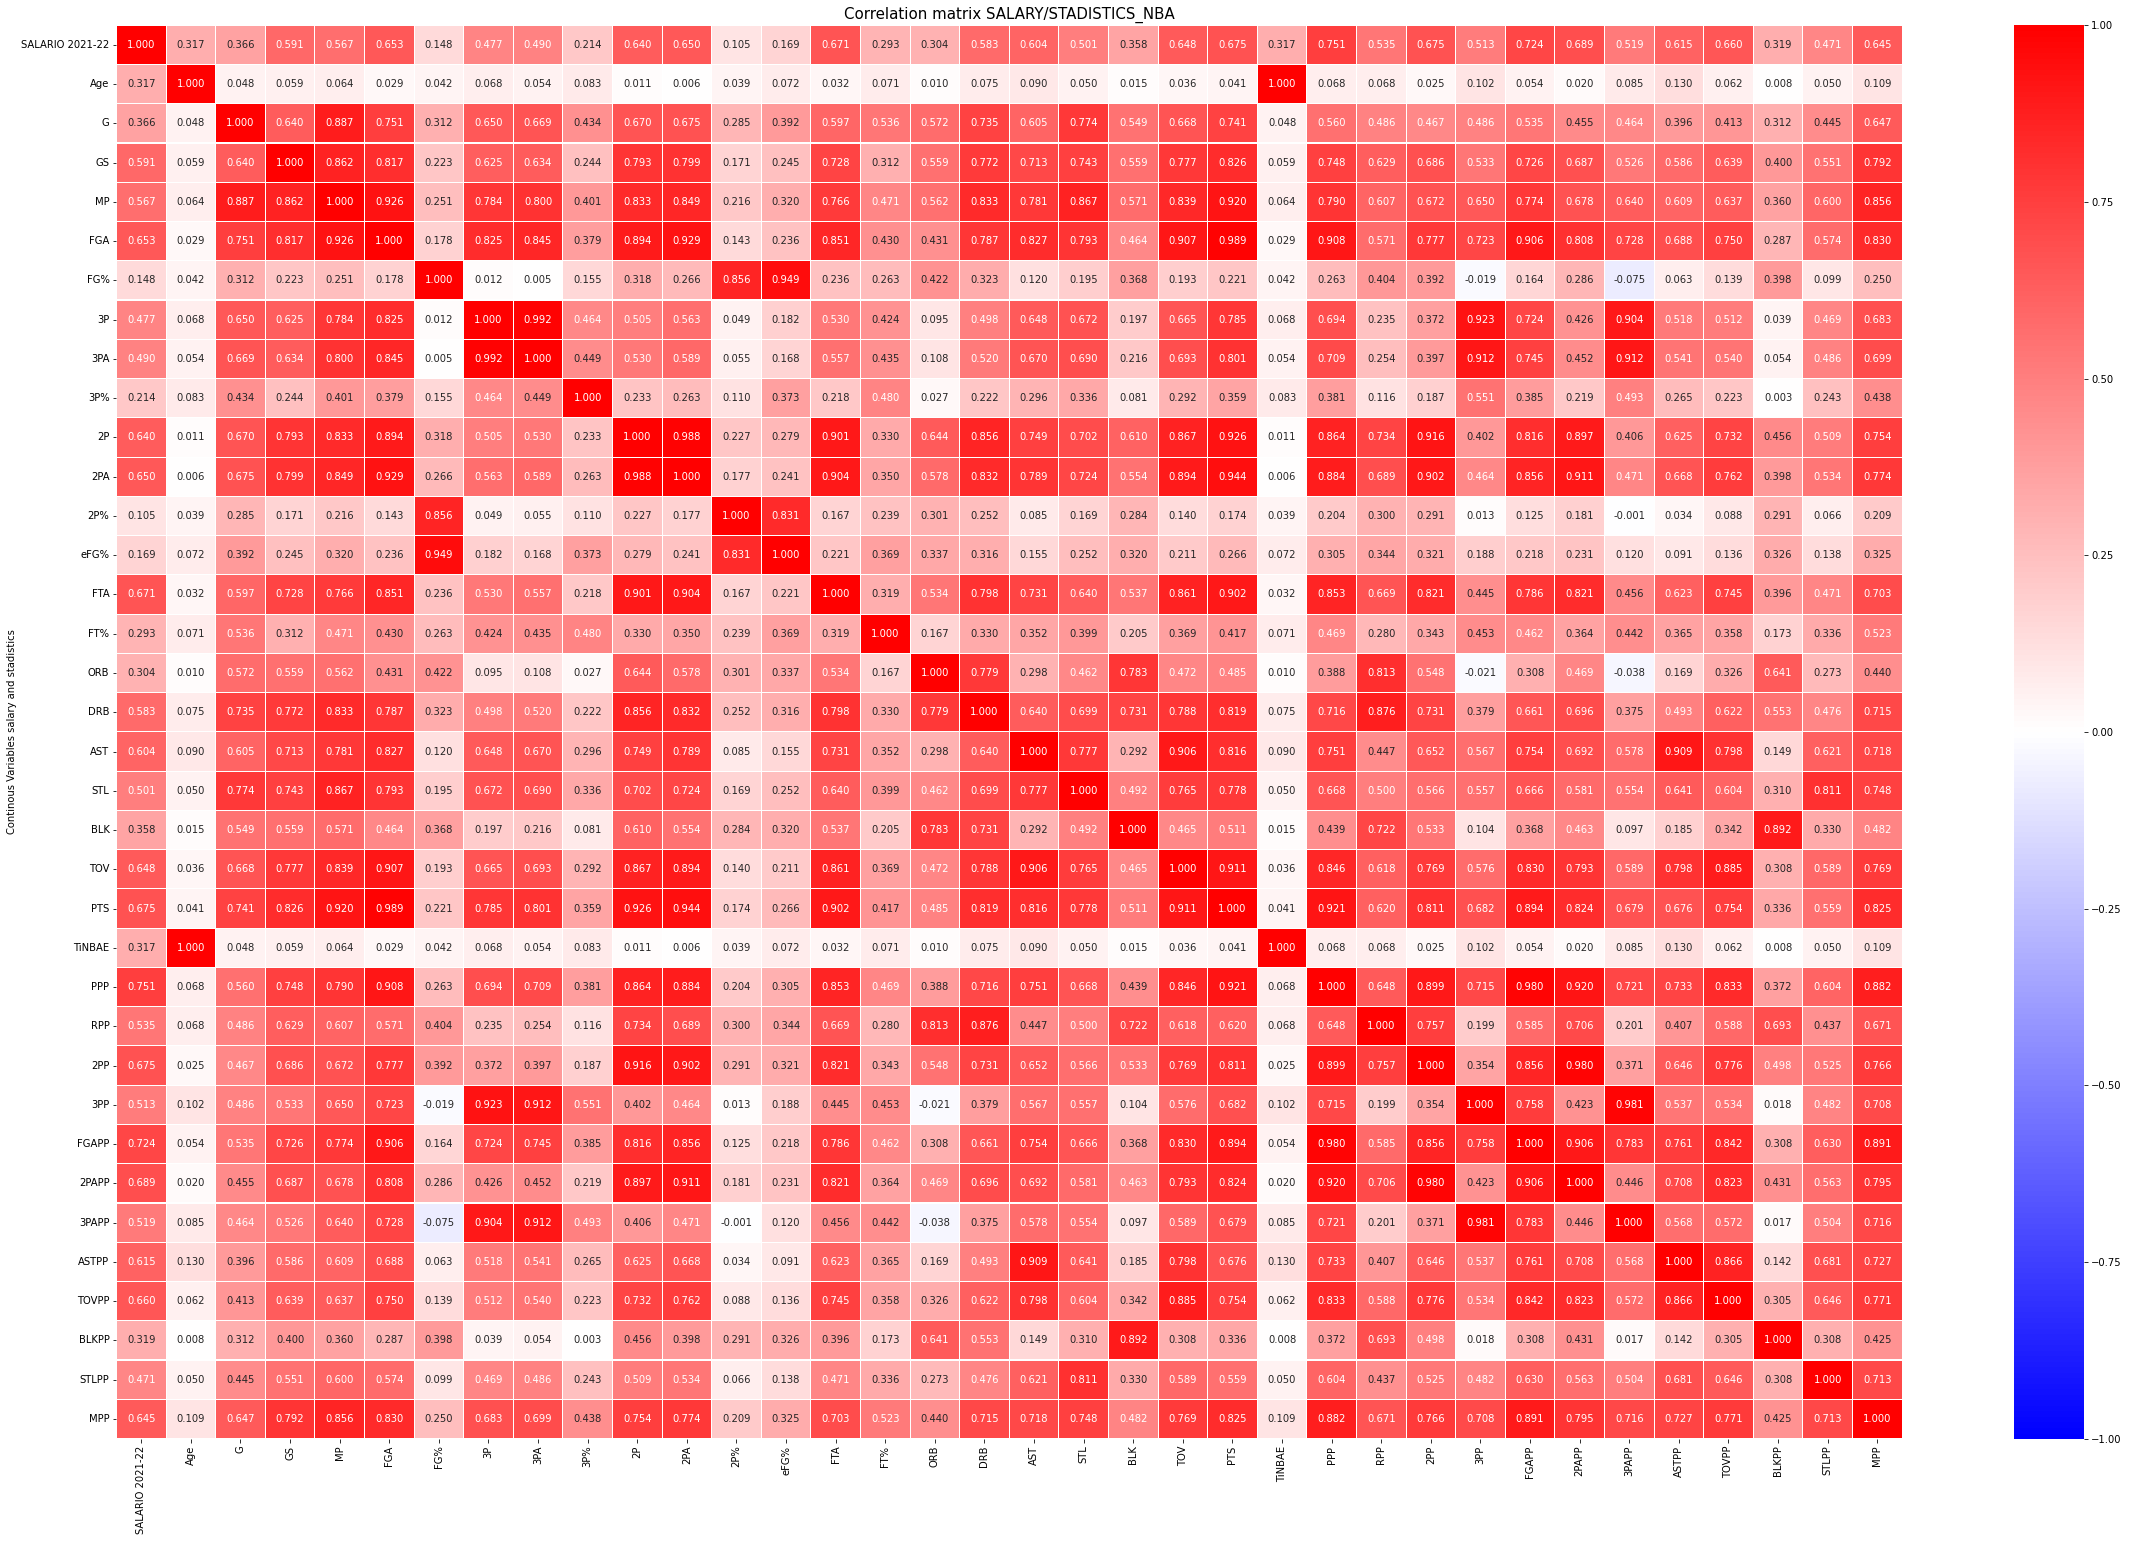

In [66]:
Proyecto.Correlation_Matrix(Proyecto.Normalizer())

In [67]:
Proyecto.Split_and_Dummy_Data(Proyecto.Normalizer())

In [68]:
Proyecto.Grid_Search_and_Fit()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [69]:
Proyecto.Create_Excel()

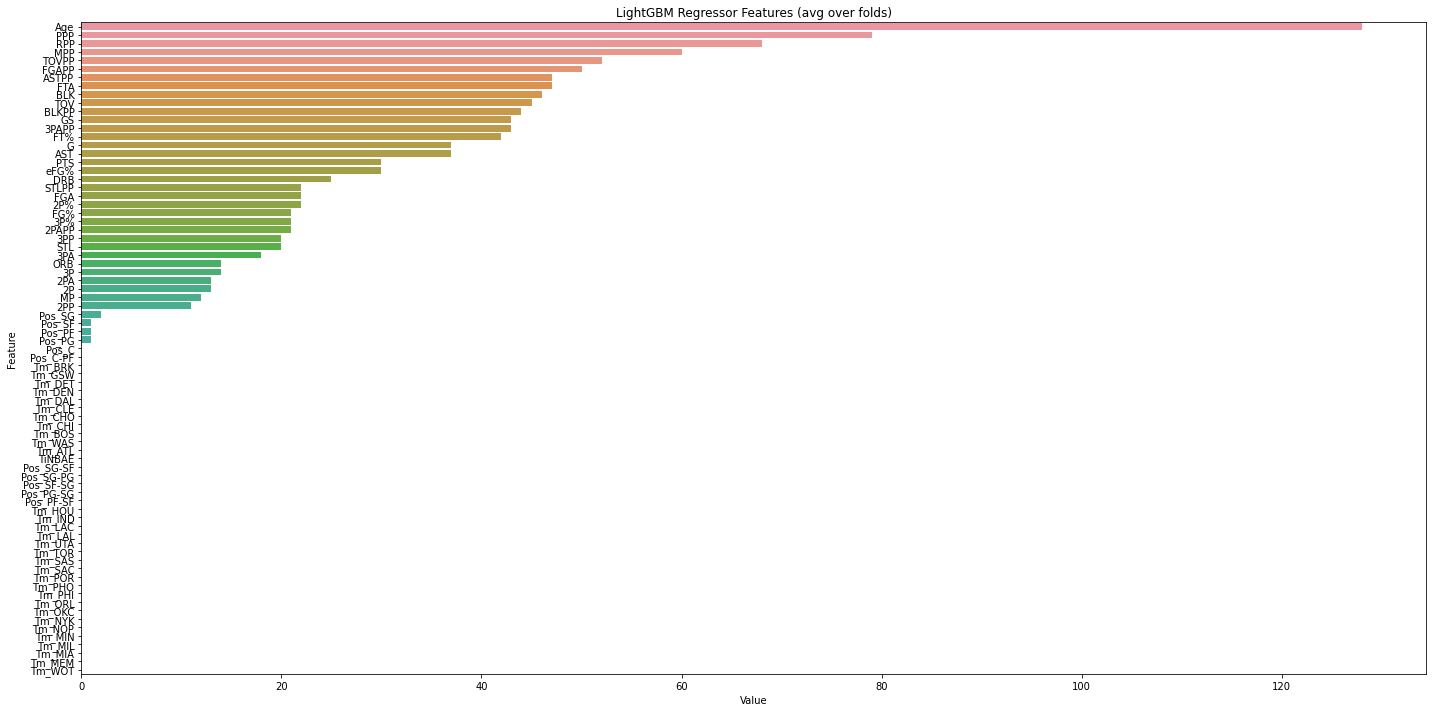

In [70]:
Proyecto.Feature_Importance()

In [71]:
Proyecto.Permutation_Importance_Features()

Weight,Feature
0.3980 ± 0.0625,PPP
0.2269 ± 0.0456,Age
0.0418 ± 0.0090,RPP
0.0328 ± 0.0082,MPP
0.0295 ± 0.0077,FGAPP
0.0198 ± 0.0058,GS
0.0187 ± 0.0061,FTA
0.0185 ± 0.0038,2PAPP
0.0153 ± 0.0045,3PAPP
0.0144 ± 0.0027,ASTPP


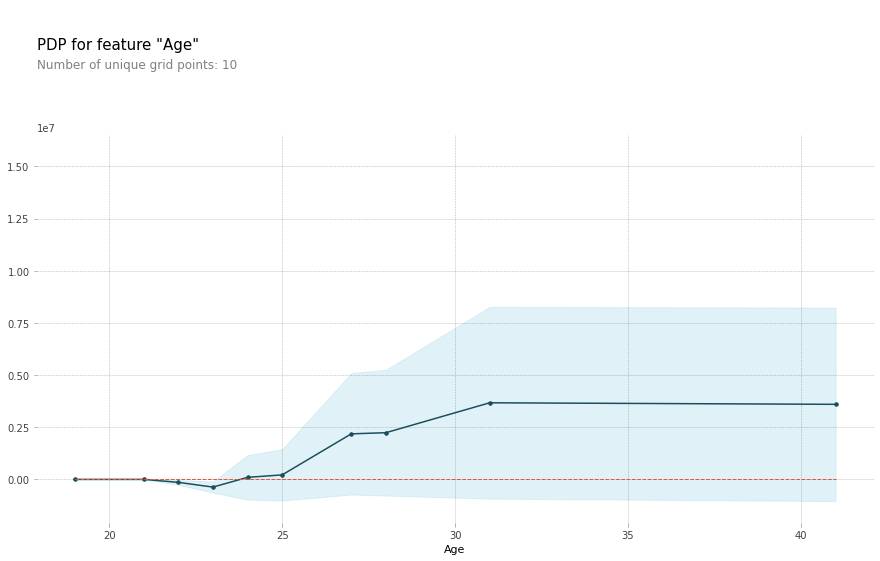

In [72]:
Proyecto.PDP(feature_number=0)

In [73]:
Proyecto.Features_Report()

,Feature_Name
0,Age
1,G
2,GS
3,MP
4,FGA
5,FG%
6,3P
7,3PA
8,3P%
9,2P


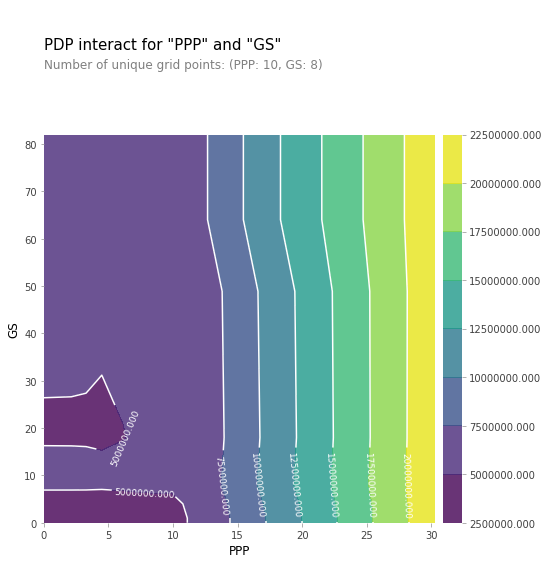

In [74]:
Proyecto.Heatmap_Salary(feature1_number=23, feature2_number=2)

In [75]:
Proyecto.Shap_Individual(14)

Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


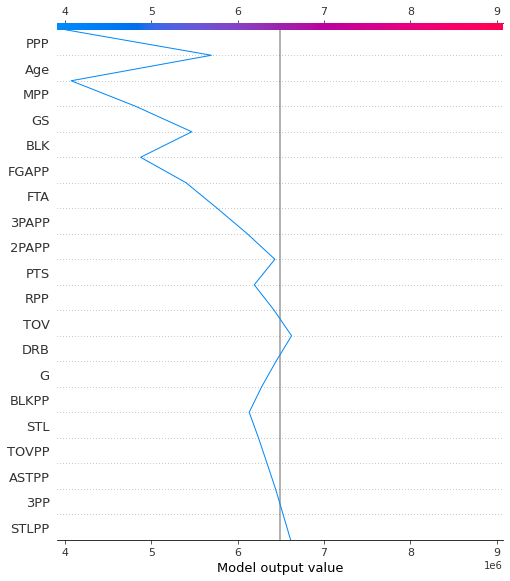

In [76]:
Proyecto.Shap_Individual_Decision_Plot(14)

In [59]:
Proyecto.Report_Player(4)

El salario actual del jugador:
Ja Morant
es de la cantidad de:
9603360.0
y el modelo predice que debería cobrar:
21393129.424374994
El salario actual del jugador:
Terence Davis
es de la cantidad de:
4000000.0
y el modelo predice que debería cobrar:
3584061.9685635194
El salario actual del jugador:
Tyrell Terry *
es de la cantidad de:
1517981.0
y el modelo predice que debería cobrar:
1030764.9154283088
El salario actual del jugador:
Devon Dotson *
es de la cantidad de:
239291.0
y el modelo predice que debería cobrar:
417912.161552304


In [77]:
Proyecto.Save_Model()